In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D, Dropout, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
import tensorflow.keras

data = pd.read_csv("./CSV/Scenario-A/merged_5s.csv")
data.head()

# check missing values
data.isnull().any().value_counts()

# fill the missing values with the previous values in that row
data.fillna(method = 'ffill',inplace = True)

# check again and confirm
data.isnull().any().value_counts()

drops = [' Destination IP', 'Source IP', ' Source Port', ' Destination Port', ' Protocol']
data.drop(drops, axis=1, inplace=True)

data.shape
data.columns

# drop null columns
nullColumns = data.columns[data.isna().any()].tolist()
data[nullColumns].isna().sum()
# dropColumn = [' Flow Bytes/s']
# data.drop(dropColumn, axis = 1, inplace = True)

x = data.drop('label', axis = 1)
y = data['label']
y = pd.DataFrame(y, columns=['label'])

# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# yLabel = le.fit_transform(y)
# # print(type(yLabel))

# yLabels = pd.DataFrame(yLabel, columns=['label'])
# # print(yLabels.groupby('label').size())

# print(x.shape)
y_train = np.asarray(y)

for i in range(0, 84194):
    if(y_train[i] == "TOR"):
        y_train[i] = 1
    else:
        y_train[i] = 0
print(y_train)

y_train = np.asarray(y_train).astype(np.float64)

# check x_train array for inf values
assert not np.any(np.isnan(x))
x_train = np.asarray(x).astype(np.float64)
array_has_inf = np.isinf(x_train)

# replace inf values with zeros
x_train[~np.isfinite(x_train)] = 0
array_has_inf = np.isinf(x_train)
y = y_train.copy()
x = x_train.copy()
x.shape
y.shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=10)

x_train_rnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_rnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_train_rnn = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test_rnn = y_test.reshape(y_test.shape[0], y_train.shape[1], 1)

# rnn model
model = Sequential()
initializer = tf.keras.initializers.GlorotUniform()

model.add(LSTM(128, input_shape=(x_train_rnn.shape[1:]), activation='tanh', return_sequences=True, kernel_initializer=initializer))
model.add(Dropout(0.2))

model.add(LSTM(64, input_shape=(x_train_rnn.shape[1:]), activation='tanh', return_sequences=True, kernel_initializer=initializer))
model.add(Dropout(0.2))

model.add(LSTM(32, input_shape=(x_train_rnn.shape[1:]), activation='tanh', return_sequences=False, kernel_initializer=initializer))
model.add(Dropout(0.2))

num_classes = 2;
model.add(Dense(num_classes, activation='softmax', kernel_initializer=initializer))
print(model.summary())

opt = tf.keras.optimizers.Adam(lr = 1e-3, decay = 1e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

result = model.fit(x_train_rnn, y_train_rnn, epochs = 30, validation_data= (x_test_rnn, y_test_rnn))

[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 23, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 23, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)       

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


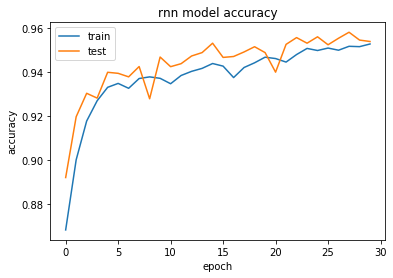

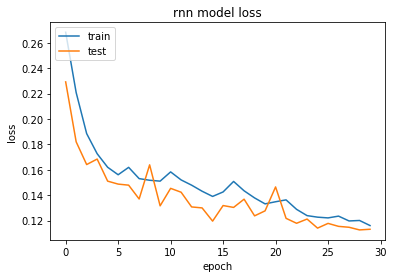

In [2]:
import matplotlib.pyplot as plt

print(result.history.keys())

# accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('rnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('rnn model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()